In [1]:
%load_ext autoreload
%autoreload 2

## Initialization

In [2]:
import sys, string, random
from datetime import datetime
from omegaconf import OmegaConf
# import wandb
import torch
import lightning as L
# from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from monai.networks.nets import UNet

sys.path.append('../')
from data_utils import MNMv2DataModule
from unet import LightningSegmentationModel

import matplotlib.pyplot as plt

# INIT DEVICE
DEVICE_LOCATION = "cuda:2"
device = torch.device(DEVICE_LOCATION if torch.cuda.is_available() else "cpu")
print(device)
# Note: I dont understand why but when i explicitly choose cuda:2
# it still defaults to gpu 0, so for now it is global
torch.cuda.set_device(2)

# load configs
mnmv2_config   = OmegaConf.load('../../configs/mnmv2.yaml')
unet_config    = OmegaConf.load('../../configs/monai_unet.yaml')
trainer_config = OmegaConf.load('../../configs/test/unet_trainer.yaml')

# init datamodule
datamodule = MNMv2DataModule(
    data_dir=mnmv2_config.data_dir,
    vendor_assignment=mnmv2_config.vendor_assignment,
    batch_size=mnmv2_config.batch_size,
    binary_target=mnmv2_config.binary_target,
    non_empty_target=mnmv2_config.non_empty_target,
)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not in

Loading of an existing model:

In [3]:
datamodule.setup()

In [4]:
checkpoint_path = '../pre-trained/trained_UNets/mnmv2-00-02_22-11-2024-v1.ckpt'

load_as_lightning_module = True
load_as_pytorch_module = False


if load_as_lightning_module:
    unet_config    = OmegaConf.load('../../configs/monai_unet.yaml')
    unet = UNet(
        spatial_dims=unet_config.spatial_dims,
        in_channels=unet_config.in_channels,
        out_channels=unet_config.out_channels,
        channels=[unet_config.n_filters_init * 2 ** i for i in range(unet_config.depth)],
        strides=[2] * (unet_config.depth - 1),
        num_res_units=4
    )
    model = LightningSegmentationModel.load_from_checkpoint(
        checkpoint_path,
        map_location=device,#torch.device("cpu"),
        model=unet,
        binary_target=True if unet_config.out_channels == 1 else False,
        lr=unet_config.lr,
        patience=unet_config.patience,
        # cfg=OmegaConf.to_container(unet_config)
    )

elif load_as_pytorch_module:
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device)) #"cpu"
    model_state_dict = checkpoint['state_dict']
    model_state_dict = {k.replace('model.model.', 'model.'): v for k, v in model_state_dict.items() if k.startswith('model.')}
    model_config = checkpoint['hyper_parameters']['cfgs']

    print(model_config)

    unet = UNet(
        spatial_dims=model_config['unet']['spatial_dims'],
        in_channels=model_config['unet']['in_channels'],
        out_channels=model_config['unet']['out_channels'],
        channels=[model_config['unet']['n_filters_init'] * 2 ** i for i in range(model_config['unet']['depth'])],
        strides=[2] * (model_config['unet']['depth'] - 1),
        num_res_units=4
    )

    unet.load_state_dict(model_state_dict)

print(f"Loaded as {'Lightning module' if load_as_lightning_module else 'PyTorch module'}")

Loaded as Lightning module


Taking some sample

In [5]:
data_sample = next(iter(datamodule.val_dataloader()))

data_sample['input'].size() # batch size, channels, width, hegiht

torch.Size([32, 1, 256, 256])

Using hooks to capture hidden layer activations

In [6]:
from torch import nn, Tensor
from adapters.layer_adapter import LayerAdapter
from adapters.model_adapter import ModelAdapter

### Example usage ###
#  run an example
n = 10

# select some layers at random
layer_names = [layer[0] for layer in unet.named_modules() if 'conv' in layer[0]]
# selection = [
#     layer_names[i] for i in torch.randperm(len(layer_names))[-n:]
# ]
selection = layer_names

# create adapters for these layers and wrap them in a wrapper
adapters = nn.ModuleList(
    [LayerAdapter(swivel) for swivel in selection]
)

wrapper = ModelAdapter(
    model=unet,
    adapters=adapters,
    map_location=device,
)
wrapper.hook_adapters()

# do a forward pass and inspect results
input_batch = data_sample['input']
_ = wrapper.forward(input_batch.cuda())

device location=cuda:2


## Experiments

In [7]:
import torch.nn.functional as F
from dimensionality_reduction import mds_to_rgb, pca_to_rgb
import numpy as np
from skimage.color import rgb2lab, lab2rgb

In [8]:
input_size = list(input_batch.size())[-2:]
input_size

[256, 256]

In [ ]:
# for mds selection id=50,10 do not work; work: 100
example = wrapper.layer_activations[selection[100]][0].detach().numpy()

print('example tensor size:', example.shape)
example_image = mds_to_rgb(example)
print(example_image.shape)

example tensor size: (16, 128, 128)
(16384, 16)


KeyboardInterrupt: 

In [9]:
COLOR_MAP = 'viridis'

def reduce_layer(layer_name, batch_count):
    """ here PCA is used """
    img_pca = pca_to_rgb(wrapper.layer_activations[layer_name][batch_count].detach().numpy())
    print('PCA shape:', img_pca.shape)
    
    return img_pca


def upscale_feature(feature_map, new_shape=input_size):
    """ Nearest Neighbor Upsampling (each pixel is duplicated to fill the gaps) """
    feature_tensor = torch.tensor(feature_map).permute(2, 0, 1).unsqueeze(0)  # Shape: (1, 3, 32, 32)
    feature_upscaled = F.interpolate(feature_tensor, size=new_shape, mode='nearest')
    # smoother version:
    # return F.interpolate(feature_map, size=(input_height, input_width), mode='bilinear', align_corners=False)
    return feature_upscaled.squeeze(0).permute(1, 2, 0).numpy()


def normalize(data):
    """ set to range 0..1 """
    return (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))


def visualize_lab_components(feature_map):
    feature_map_lab = rgb2lab(feature_map)
    
    # Visualize each Lab channel
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = ['L (Lightness)', 'a (Green-Red)', 'b (Blue-Yellow)']
    
    for i in range(3):
        axes[i].imshow(feature_map_lab[..., i], cmap=COLOR_MAP)
        axes[i].axis('off')
        axes[i].set_title(titles[i])
    
    plt.tight_layout()
    plt.show()


def plot_feature(feature_map):
    # make perceptually uniform
    feature_map_lab = rgb2lab(feature_map)
    feature_map_rgb = lab2rgb(feature_map_lab)
    
    plt.imshow(feature_map_rgb, cmap=COLOR_MAP)
    plt.axis('off')
    plt.show()

In [24]:
selection = layer_names
print(len(selection))

images = input_batch.to(device)
y = model(images).cpu().detach().numpy()
images = images.cpu()
print(y.shape)

120
(32, 4, 256, 256)



IMAGE ID 0


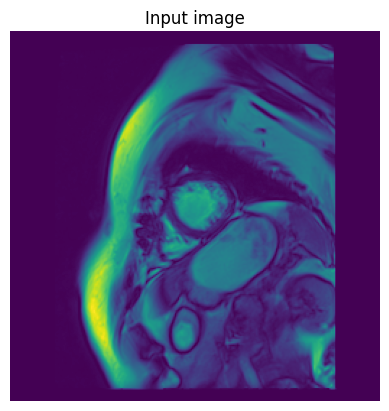

Layer to visualize: 3 of size torch.Size([16, 128, 128]) (C, H, W)
PCA shape: (128, 128, 3)


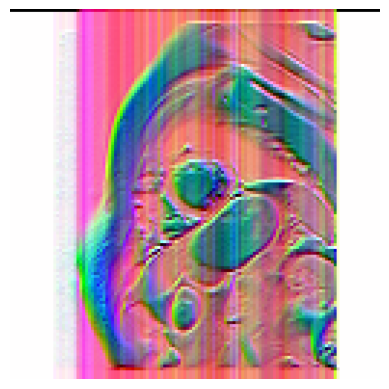

Layer to visualize: 10 of size torch.Size([16, 128, 128]) (C, H, W)
PCA shape: (128, 128, 3)


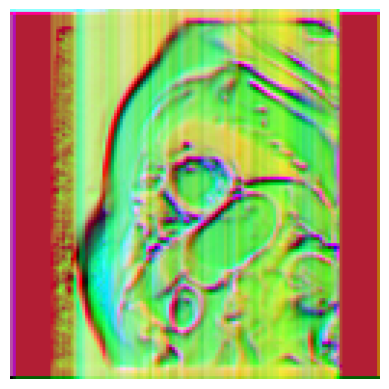

Layer to visualize: 20 of size torch.Size([16, 128, 128]) (C, H, W)
PCA shape: (128, 128, 3)


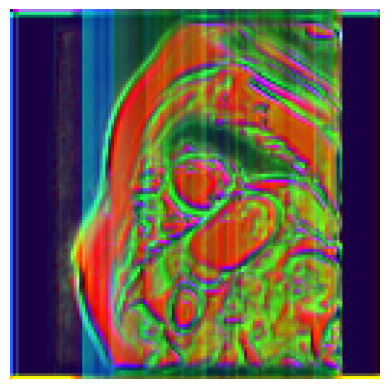

Layer to visualize: 50 of size torch.Size([32, 64, 64]) (C, H, W)
PCA shape: (64, 64, 3)


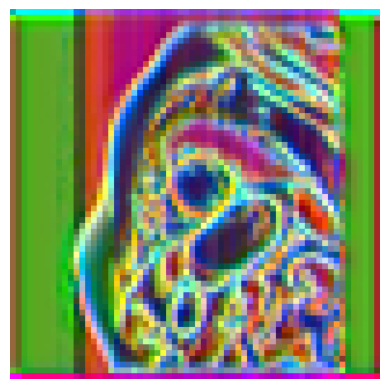

Layer to visualize: 100 of size torch.Size([192, 32, 32]) (C, H, W)
PCA shape: (32, 32, 3)


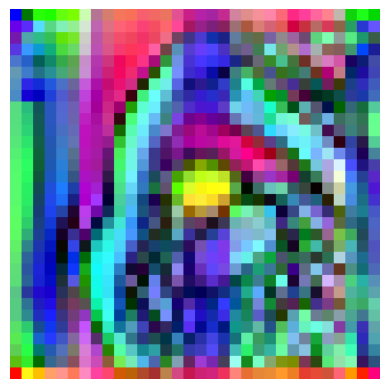

Layer to visualize: 110 of size torch.Size([16, 128, 128]) (C, H, W)
PCA shape: (128, 128, 3)


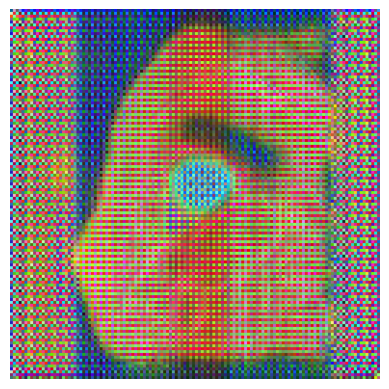

Layer to visualize: -1 of size torch.Size([4, 256, 256]) (C, H, W)
PCA shape: (256, 256, 3)


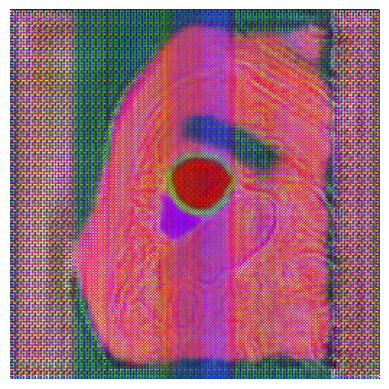

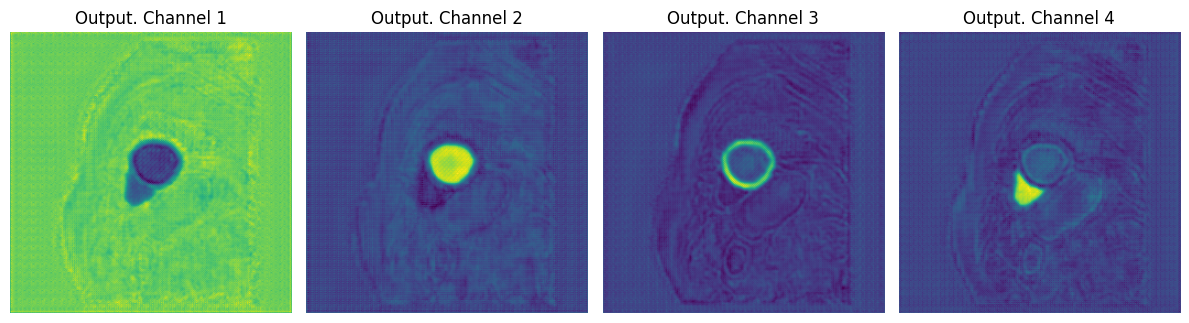

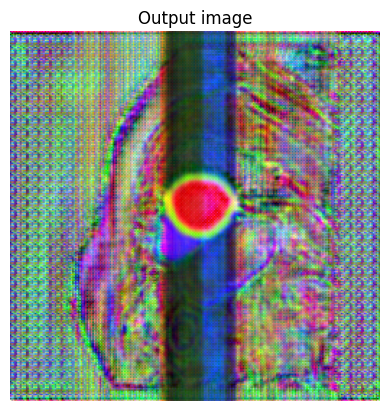


IMAGE ID 30


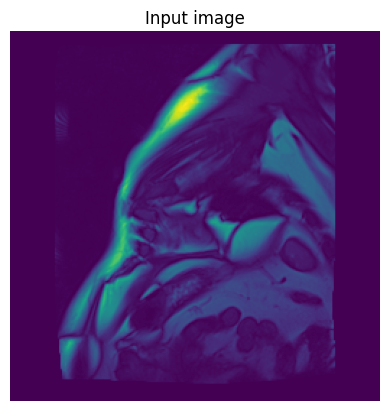

Layer to visualize: 3 of size torch.Size([16, 128, 128]) (C, H, W)
PCA shape: (128, 128, 3)


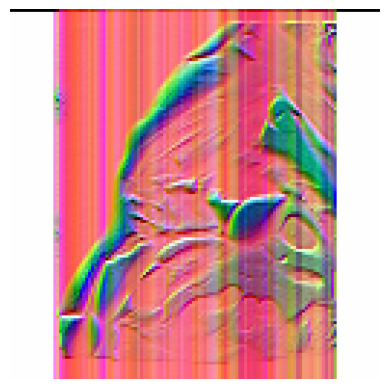

Layer to visualize: 10 of size torch.Size([16, 128, 128]) (C, H, W)
PCA shape: (128, 128, 3)


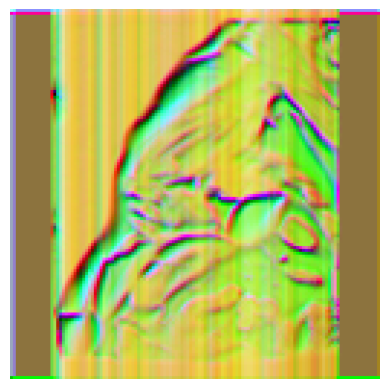

Layer to visualize: 20 of size torch.Size([16, 128, 128]) (C, H, W)
PCA shape: (128, 128, 3)


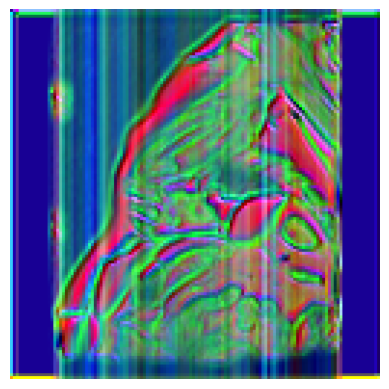

Layer to visualize: 50 of size torch.Size([32, 64, 64]) (C, H, W)
PCA shape: (64, 64, 3)


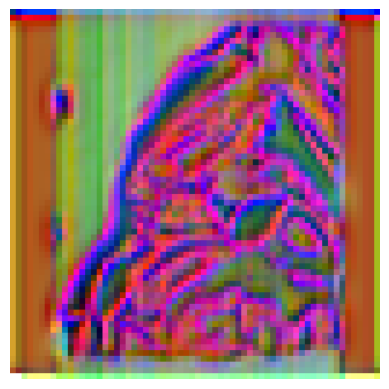

Layer to visualize: 100 of size torch.Size([192, 32, 32]) (C, H, W)
PCA shape: (32, 32, 3)


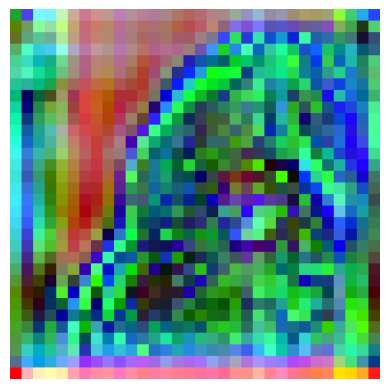

Layer to visualize: 110 of size torch.Size([16, 128, 128]) (C, H, W)
PCA shape: (128, 128, 3)


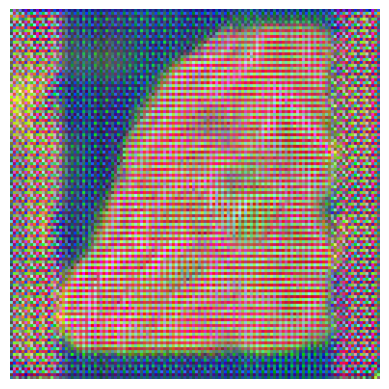

Layer to visualize: -1 of size torch.Size([4, 256, 256]) (C, H, W)
PCA shape: (256, 256, 3)


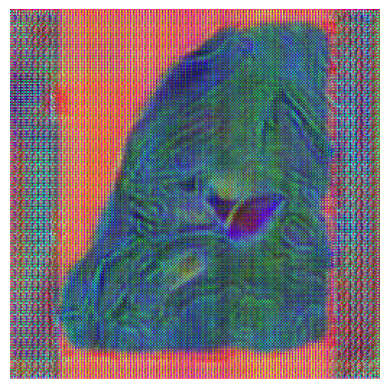

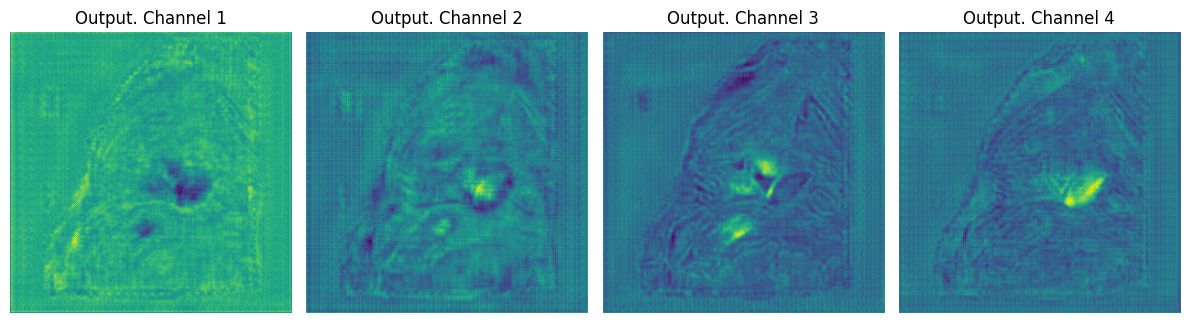

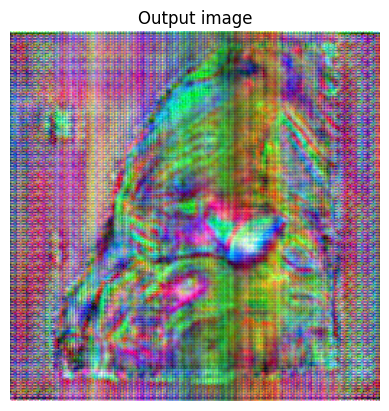

In [ ]:
LAYER_SELECTION = [3,10,20,50,100,110,-1]
IMAGE_IDS = [0, 30] # id of an image in the batch (range 0..31)

for image_id in IMAGE_IDS:
    print()
    print('IMAGE ID', image_id)

    # display input image
    plt.imshow(images[image_id].permute(1, 2, 0).numpy(), cmap=COLOR_MAP)
    plt.title("Input image")
    plt.axis('off')
    plt.show()

    # visualize selected hidden layers
    for layer_id in LAYER_SELECTION:
        layer_name = selection[layer_id]
        print(f'Layer to visualize: {layer_id} of size {wrapper.layer_activations[layer_name][image_id].size()} (C, H, W)')
        # step 1: perform dimensionality reduction
        feature = reduce_layer(layer_name, image_id)
        # step 2: upscale an image (optional?)
        feature_upscaled = upscale_feature(feature)
        # step 3: normalize
        feature_normalized = normalize(feature_upscaled)
        # step 4: visualize
        plot_feature(feature_normalized)
    
    # final output visualization: channels separately and combined
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    out = y[image_id]
    for idx, channel in enumerate(out):
        axs[idx].imshow(channel)
        axs[idx].set_title(f"Output. Channel {idx+1}")
        axs[idx].axis("off")
    plt.tight_layout()
    plt.show()
    plt.imshow(normalize(pca_to_rgb(out)), cmap=COLOR_MAP)
    plt.title("Output image")
    plt.axis('off')
    plt.show()
    